# Component split enrichment
14th Apr

Comparing mpnn and morgan fingerprints on data splitting by ugi component.

### Data processing

Let's load the moonshot data first

In [1]:
import pandas as pd
import numpy as np

from dock2hit.fine_tuning.process_data import read_and_process_ugi_data

df_ugi_data = read_and_process_ugi_data().query('data_source != "new"')


INFO:rdkit:Enabling RDKit 2021.09.4 jupyter extensions
INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
INFO:root:No GPU found, using CPU
/tmp/ipykernel_2010248/30041110.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2010248/30041110.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Visualise pIC50 distribution

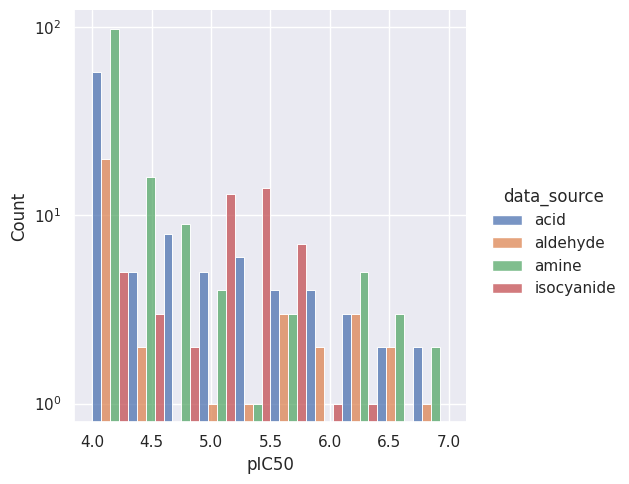

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.dpi": 100})

sns.displot(data=df_ugi_data, x="pIC50",
            hue="data_source", multiple="dodge", bins=10)
plt.yscale('log')
plt.gca().get_yaxis().set_tick_params(which='minor')
plt.show()


### Component-Split Evaluation

In [9]:
from tqdm import tqdm
from dock2hit.fine_tuning import train_and_score

print('Fitting RF models')

n_models = 1

dfs_with_scores = []

tautomer_mpnn = '/rds-d2/user/wjm41/hpc-work/models/dock2hit/ugi/ugi_taut/model_mol9039221.ckpt'
for component in df_ugi_data.data_source.unique():
    df_training_set = df_ugi_data.query(f'data_source != @component')
    df_test_set = df_ugi_data.query(f'data_source == @component').copy()
    
    df_score = train_and_score(
        df_test_set, input_rep='mpnn_fp', n_models=n_models, model_ckpt=tautomer_mpnn, df_training_data=df_training_set)
    
    df_score_morgan = train_and_score(df_test_set, input_rep='morgan_fp', n_models=n_models,
                                                    model_ckpt=tautomer_mpnn, df_training_data=df_training_set)
    df_score['morgan_fp_pred_mean'] = df_score_morgan['morgan_fp_pred_mean'].values
    df_score['predicted_IC50_morgan_fp'] = df_score_morgan['predicted_IC50_morgan_fp'].values
    # raise Exception
    dfs_with_scores.append(df_score)
    
df_with_predictions = pd.concat(dfs_with_scores)

Fitting RF models
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 604, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 2, 'bootstrap': False}
    index                                             SMILES     IC50  \
0       0  CC(C)(C)c1ccc(N(C(=O)c2cnon2)C(C(=O)NCCc2cccc(...    8.410   
1       1  CC(C)(C)c1ccc(N(C(=O)c2cnsn2)C(C(=O)NCCc2cccc(...   13.200   
2       2  CC(C)(C)c1ccc(N(C(=O)c2cscn2)C(C(=O)NCCc2cccc(...    0.891   
3       3  CC(C)(C)c1ccc(N(C(=O)c2nn[nH]n2)C(C(=O)NCCc2cc...  100.000   
4       4  CC(C)(C)c1ccc(N(C(=O)c2ccno2)C(C(=O)NCCc2cccc(...    1.110   
..    ...                                                ...      ...   
92     92  CC(C)(C)c1ccc(N(C(=O)c2ccco2)C(C(=O)NCCc2cccc(...    2.530   
93     93  C=CC(=O)N(c1ccc(C(C)(C)C)cc1)C(C(=O)NCCc1cccc(...    7.480   
94     94  C=CC(=O)N(c1ccc(C(C)(C)C)cc1)C(C(=O)NCCc1cccc(...   11.600   
95     95  C=CC(=O)N(c1ccc(C(C)(C)C)cc1)C(C(=O)NCCc1cccc(...   1

In [10]:
import plotly.express as px

from sklearn.metrics import r2_score
from scipy.stats import spearmanr


def print_regression_metrics(scored_dataframe, query_string, input_rep, data_name, pIC50=True):

    if pIC50:
        r2_coefficient = r2_score(scored_dataframe.query(query_string)[
            'pIC50'], scored_dataframe.query(query_string)[f'{input_rep}_pred_mean'])
        rho_coefficient = spearmanr(scored_dataframe.query(query_string)[
            'pIC50'], scored_dataframe.query(query_string)[f'{input_rep}_pred_mean'])[0]

    else:
        r2_coefficient = r2_score(scored_dataframe.query(query_string)[
            'IC50'], scored_dataframe.query(query_string)[f'predicted_IC50_{input_rep}'])
        rho_coefficient = spearmanr(scored_dataframe.query(query_string)[
            'IC50'], scored_dataframe.query(query_string)[f'predicted_IC50_{input_rep}'])[0]

    print(f'R2 score on {data_name} ({input_rep}): {r2_coefficient:.3f}')
    print(f'rho score on {data_name} ({input_rep}): {rho_coefficient:.3f}')
    return


for component in df_ugi_data.data_source.unique():
    component_query = 'data_source == @component & IC50 < 90'
    print_regression_metrics(df_with_predictions, query_string=component_query,
                             input_rep='mpnn_fp', data_name=f'Ugi {component} mpnn_fp: ')
    print_regression_metrics(df_with_predictions, query_string=component_query,
                             input_rep='morgan_fp', data_name=f'Ugi {component} morgan_fp: ')
    fig_scatter = px.scatter(df_with_predictions.query(component_query),
                             x='IC50',
                             y='predicted_IC50_mpnn_fp',
                             log_x=True,
                             log_y=True,
                             height=800,
                             title=f'IC50 predictions for {component}')

    fig_scatter_morgan = px.scatter(df_with_predictions.query(component_query),
                                    x='IC50',
                                    y='predicted_IC50_morgan_fp',
                                    color_discrete_sequence=['red'],
                                    log_x=True,
                                    log_y=True)

    fig_scatter['data'][0]['showlegend'] = True
    fig_scatter['data'][0]['name'] = 'mpnn_fp'
    fig_scatter_morgan['data'][0]['showlegend'] = True
    fig_scatter_morgan['data'][0]['name'] = 'morgan_fp'

    fig_scatter.add_trace(fig_scatter_morgan.data[0])
    fig_scatter.add_shape(type='line',
                        x0=0.1,
                        x1=100,
                        y0=0.1,
                        y1=100,
                        line=dict(color='black', dash='dash'))
    fig_scatter.show()


R2 score on Ugi acid mpnn_fp:  (mpnn_fp): 0.204
rho score on Ugi acid mpnn_fp:  (mpnn_fp): 0.638
R2 score on Ugi acid morgan_fp:  (morgan_fp): -1.022
rho score on Ugi acid morgan_fp:  (morgan_fp): 0.455


R2 score on Ugi aldehyde mpnn_fp:  (mpnn_fp): -0.456
rho score on Ugi aldehyde mpnn_fp:  (mpnn_fp): 0.686
R2 score on Ugi aldehyde morgan_fp:  (morgan_fp): -0.575
rho score on Ugi aldehyde morgan_fp:  (morgan_fp): 0.686


R2 score on Ugi amine mpnn_fp:  (mpnn_fp): 0.347
rho score on Ugi amine mpnn_fp:  (mpnn_fp): 0.551
R2 score on Ugi amine morgan_fp:  (morgan_fp): -0.148
rho score on Ugi amine morgan_fp:  (morgan_fp): 0.510


R2 score on Ugi isocyanide mpnn_fp:  (mpnn_fp): -5.490
rho score on Ugi isocyanide mpnn_fp:  (mpnn_fp): -0.156
R2 score on Ugi isocyanide morgan_fp:  (morgan_fp): -2.438
rho score on Ugi isocyanide morgan_fp:  (morgan_fp): -0.173


In [11]:
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.stats import spearmanr


def calculate_enrichment_for_df(score_df, n=10, score='score', index='active', log=False, ascending=True):

    df = score_df[score_df[score].notna()]
    orig_prop = len(df[df[index]])/len(df)
    if log:
        print('orig proportion of {}: {:.3f}%'.format(index, orig_prop*100))

    sorted_df = df.sort_values(by=score, ascending=ascending).iloc[:n]
    new_prop = len(sorted_df[sorted_df[index]])/len(sorted_df)
    if log:
        print('N = {}, n_hits = {}, new proportion of {}: {:.3f}%'.format(
            n, len(sorted_df[sorted_df[index]]), index, new_prop*100))
    EF = new_prop/orig_prop
    return EF


def plot_enrichment_mpnn_vs_morgan(df_to_plot, title='Not Specified!', try_both=False):
    n_list = np.logspace(start=np.log10(5), stop=2, num=20)
    EF_morgan = [calculate_enrichment_for_df(
        df_to_plot, n=int(n), index='hit', score='predicted_IC50_morgan_fp', ascending=True) for n in n_list]
    EF_mpnn = [calculate_enrichment_for_df(
        df_to_plot, n=int(n), index='hit', score='predicted_IC50_mpnn_fp', ascending=True) for n in n_list]

    orig_prop = len(
        df_to_plot[df_to_plot['hit']])/len(df_to_plot)

    plt.plot(n_list, EF_morgan, label='morgan fp')
    plt.plot(n_list, EF_mpnn, label='mpnn fp')

    plt.plot(n_list, np.ones_like(n_list), 'k:')
    plt.legend()
    plt.title(f'morgan vs mpnn enrichment\n{title}')
    plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
    extraticks = [1]
    plt.yticks(list(plt.yticks()[0]) + extraticks)
    plt.ylim(bottom=0)


def plot_enrichment_variable_component_variable_threshold(component, ic50_threshold):
    component_query = 'data_source == @component'
    df_component = df_with_predictions.query(component_query)
    df_component['hit'] = df_component['IC50'] < ic50_threshold
    rho_morgan_vs_mpnn = spearmanr(
        df_component['predicted_IC50_morgan_fp'].values, df_component['predicted_IC50_mpnn_fp'].values)[0]
    rho_ic50_vs_mpnn = spearmanr(df_component.dropna()['IC50'].values,
                                 df_component.dropna()['predicted_IC50_mpnn_fp'].values)[0]
    rho_ic50_vs_morgan = spearmanr(df_component.dropna()['predicted_IC50_morgan_fp'].values,
                                   df_component.dropna()['predicted_IC50_mpnn_fp'].values)[0]
    print(f'rho morgan vs mpnn {rho_morgan_vs_mpnn:.2f}')
    print(f'rho morgan vs IC50 {rho_ic50_vs_morgan:.2f}')
    print(f'rho mpnn vs IC50 {rho_ic50_vs_mpnn:.2f}')

    plot_enrichment_mpnn_vs_morgan(df_component,
                                   title=f'Ugi {component} component \n IC50 < {ic50_threshold}uM  (n={len(df_component)})')
    return


interact(plot_enrichment_variable_component_variable_threshold, ic50_threshold=(
    0.0, 100.0), component=['acid', 'amine', 'aldehyde','isocyanide'])


interactive(children=(Dropdown(description='component', options=('acid', 'amine', 'aldehyde', 'isocyanide'), v…

<function __main__.plot_enrichment_variable_component_variable_threshold(component, ic50_threshold)>